**Obter dados do período de ressaque dos últimos 6 meses**

Deve conter:

1 - valor emissão

2 - data

3 - id parceiro

In [2]:
import polars as pl

In [7]:
amostra = pl.read_csv("../input_data/amostra.csv", schema_overrides={'issue_amount': pl.Float64,
                                                                    'created_at': pl.Datetime,
                                                                    "nome_tabela": pl.String,
                                                                    'cod_master': pl.String})

In [8]:
amostra.sample(5)

issue_amount,created_at,nome_tabela,cod_master
f64,datetime[μs],str,str
176.31,2025-06-23 21:29:36.874,"""AN0010""","""10922"""
51.66,2025-06-25 13:35:28.025,"""BR0025""","""11059"""
4161.46,2025-06-24 14:17:46.029,"""BR0029""","""8173"""
186.52,2025-06-25 12:52:38.522,"""BR0025""","""12175"""
299.48,2025-06-27 17:54:40.295,"""AN0010""","""0545"""


In [9]:
amostra.shape

(202741, 4)

**Sumarizando valores**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [16]:
sumarizacao_1 = amostra.group_by('cod_master').agg(
    pl.col('issue_amount').sum().alias("total_produzido"),
    pl.count().alias("frequencia")
).sort('frequencia', descending=True)

C:\Users\Cleiton - Financeiro\AppData\Local\Temp\ipykernel_15484\589214298.py:3: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("frequencia")


**Limpando e preparando para cálculo**

In [52]:
sumarizacao_1.sample(5)

cod_master,total_produzido,frequencia
str,f64,u32
"""10793""",844.69,2
"""7203""",1434.81,3
"""7842""",7838.48,28
"""7613""",165320.81,566
"""7696""",2829.81,1


In [55]:
frequencia = sumarizacao_1['frequencia'].drop_nulls().to_numpy()
valor = sumarizacao_1['total_produzido'].drop_nulls().to_numpy()

In [81]:
# Outliers - com base no zscore
media = np.mean(frequencia)
desvio = np.std(frequencia)
z_scores = (frequencia - media) / desvio
limiar = 3
outliers = z_scores > limiar



In [82]:
outliers

array([ True,  True,  True, ..., False, False, False])

In [83]:
outliers_groupy = sumarizacao_1.filter(pl.Series(outliers))
not_outliers_groupy = sumarizacao_1.filter(pl.Series(~outliers))

In [84]:
# distribuição
frequencia_log = np.log(not_outliers_groupy['frequencia'])
frequencia_log

frequencia
f64
7.96728
7.892078
7.853993
7.844633
7.716461
…
0.0
0.0
0.0


(array([132., 116., 150., 170., 177., 144., 101.,  48.,  27.,  15.]),
 array([0.        , 0.79672802, 1.59345604, 2.39018405, 3.18691207,
        3.98364009, 4.78036811, 5.57709613, 6.37382414, 7.17055216,
        7.96728018]),
 <BarContainer object of 10 artists>)

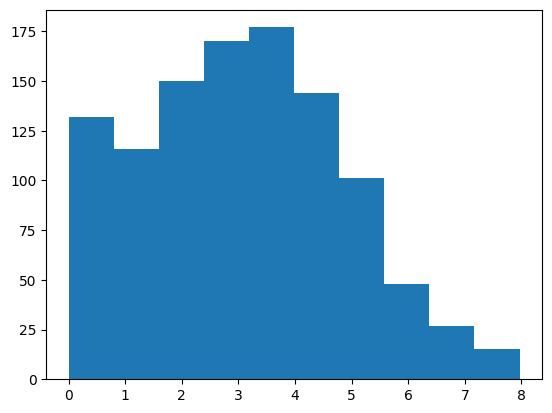

In [85]:
plt.hist(frequencia_log)

In [86]:
kmeans = KMeans(8)

In [90]:
k_v1 = kmeans.fit(not_outliers_groupy['frequencia'].to_numpy().reshape(-1, 1))
labels = k_v1.labels_
labels

array([3, 3, 3, ..., 0, 0, 0])

In [91]:
df_clusterized = not_outliers_groupy.with_columns(pl.Series(name = 'cluster', values=labels))

In [92]:
df_clusterized.sample(5)

cod_master,total_produzido,frequencia,cluster
str,f64,u32,i32
"""7821""",383.43,1,0
"""7767""",10274.51,57,4
"""0457""",27462.75,35,0
"""10113""",8508.36,28,0
"""7452""",1137.7,4,0


In [94]:
outliers_groupy_cluster = outliers_groupy.with_columns(pl.lit(9).alias('cluster'))

In [96]:
df_concated_clusterized = pl.concat([df_clusterized, outliers_groupy_cluster])

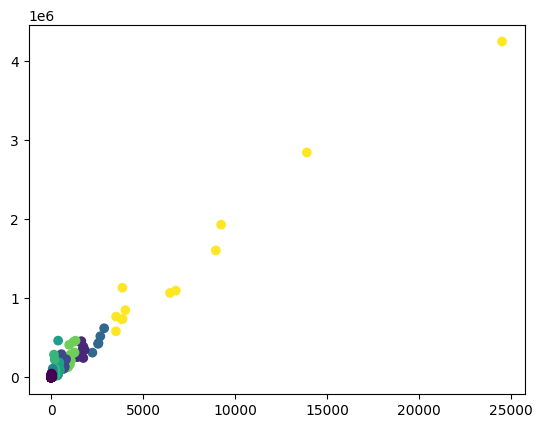

In [99]:
plt.scatter(x=df_concated_clusterized['frequencia'], y = df_concated_clusterized['total_produzido'], c = df_concated_clusterized['cluster'])

In [108]:
import seaborn as sns

In [104]:
df_concated_clusterized.sample(5)

cod_master,total_produzido,frequencia,cluster
str,f64,u32,i32
"""12229""",110538.94,122,6
"""11980""",3582.48,5,0
"""7458""",8726.04,12,0
"""7327""",661.38,4,0
"""11863""",4963.06,27,0


In [114]:
df_concated_clusterized.filter(pl.col('cluster') == 1).select(pl.col('total_produzido'), pl.col('frequencia')).describe().transpose()


column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8
str,str,str,str,str,str,str,str,str
"""count""","""null_count""","""mean""","""std""","""min""","""25%""","""50%""","""75%""","""max"""
"""9.0""","""0.0""","""339951.9133333332""","""82290.91028919366""","""246364.2""","""261253.75999999983""","""348600.62999999954""","""389193.43000000017""","""459344.1200000001"""
"""9.0""","""0.0""","""1632.5555555555557""","""145.3316131396668""","""1389.0""","""1540.0""","""1643.0""","""1750.0""","""1823.0"""
